In [15]:
import numpy as np
from numpy import ndarray
import os
from ase.io import read, iread
from ase.neighborlist import build_neighbor_list
from ase import Atoms
from itertools import combinations_with_replacement
from tqdm import tqdm_notebook
import sys
import pickle
%matplotlib inline

In [16]:
def read_poscars(pfile, step=1):
    structures = []
    counter = 0
    with open(pfile, 'r') as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if 'EA' in line:
                if counter % step == 0:
                    current_struct = []
                    num_of_atoms = sum([int(item) for item in lines[i+6].split()])
                    for line in lines[i:i+8+num_of_atoms+1]:
                        current_struct.append(line)
                    coef = float(current_struct[1])
                    cell = np.ndarray(shape=(3,3))
                    species = current_struct[5].split()
                    num_species = [int(item) for item in current_struct[6].split()]                    
                    symbols = np.repeat(species, num_species)
                    if 'Selective Dynamics' in current_struct:
                        raise NotImplementedError
                    positions = np.ndarray(shape=(num_of_atoms,3))
                    for j in range(3):
                        cell[j] = np.asarray(current_struct[j+2].split(), dtype=float)
                    cell *= coef
                    for n in range(num_of_atoms):
                        positions[n] = np.asarray(current_struct[n+8].split(), dtype=float)
                    if 'Direct' in current_struct[7]:
                        positions = np.dot(positions, cell)
                    ID = int(current_struct[0].split('EA')[-1])
                    structure = Atoms(symbols=symbols, positions=positions, cell=cell, pbc=True)
                    structure.ID = ID
                    structures.append(structure)
                counter += 1
    return structures

In [17]:
poscars = './POSCARS'
energies = np.loadtxt('./Energies_TOTEN', dtype=float)
structures = read_poscars(poscars)

In [18]:
with open('G1_001.pickle', 'rb') as f:
    G1 = pickle.load(f)
with open('G2_001.pickle', 'rb') as f:
    G2 = pickle.load(f)
with open('G4_001.pickle', 'rb') as f:
    G4 = pickle.load(f)
with open('G4Names_001.pickle', 'rb') as file:
    NamesG4 = pickle.load(file)

G1 = np.array(G1)
G2 = np.array(G2)
G4 = np.array(G4)
X = np.append(np.append(G1, G2[:,:], axis=1), G4, axis=1)

In [39]:
NAtoms = np.array([])
for iStep, struct in enumerate(structures):
    NAtoms = np.append(NAtoms, len(struct.positions))

EAtom = np.array(energies)/NAtoms

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

Y = energies
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.3)

#нормировка данных, так как далее будет использоваться градиентный спуск
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [6]:
from sklearn.metrics import mean_squared_error as mse
# "Learn" the mean from the training data
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MSE
mse_baseline = mse(y_test, baseline_predictions)
print("Baseline rMSE is {:.2f}".format(np.sqrt(mse_baseline)))

Baseline rMSE is 6.08


In [10]:
# xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.05,
#                 max_depth = 20, alpha = 10, n_estimators = 2000)

params = {
    # Parameters that we are going to tune.
    'max_depth':10,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

params['eval_metric'] = "rmse"
num_boost_round = 999
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)
print("Best rMSE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	Test-rmse:4.20435
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:3.01973
[2]	Test-rmse:2.18298
[3]	Test-rmse:1.60286
[4]	Test-rmse:1.20474
[5]	Test-rmse:0.91768
[6]	Test-rmse:0.73068
[7]	Test-rmse:0.58999
[8]	Test-rmse:0.51393
[9]	Test-rmse:0.46725
[10]	Test-rmse:0.43654
[11]	Test-rmse:0.41950
[12]	Test-rmse:0.40866
[13]	Test-rmse:0.40305
[14]	Test-rmse:0.39931
[15]	Test-rmse:0.39775
[16]	Test-rmse:0.39679
[17]	Test-rmse:0.39553
[18]	Test-rmse:0.39394
[19]	Test-rmse:0.39342
[20]	Test-rmse:0.39334
[21]	Test-rmse:0.39321
[22]	Test-rmse:0.39299
[23]	Test-rmse:0.39294
[24]	Test-rmse:0.39296
[25]	Test-rmse:0.39285
[26]	Test-rmse:0.39284
[27]	Test-rmse:0.39270
[28]	Test-rmse:0.39257
[29]	Test-rmse:0.39257
[30]	Test-rmse:0.39255
[31]	Test-rmse:0.39250
[32]	Test-rmse:0.39242
[33]	Test-rmse:0.39239
[34]	Test-rmse:0.39240
[35]	Test-rmse:0.39231
[36]	Test-rmse:0.39231
[37]	Test-rmse:0.39230
[38]	Test-rmse:0.39226
[39]	Test-rmse:0.39231
[40]	Test-rmse:0.39234
[41]	Test-

In [11]:
params = {
    # Parameters that we are going to tune.
    'max_depth':10,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

num_boost_round = 999


cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)

cv_results

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          4.361656        0.066127        4.362753       0.308821
1          3.135694        0.045705        3.154929       0.247460
2          2.263851        0.030928        2.295056       0.187281
3          1.640817        0.021673        1.687827       0.150270
4          1.195619        0.014679        1.261919       0.112826
..              ...             ...             ...            ...
57         0.002870        0.000482        0.398032       0.016368
58         0.002699        0.000410        0.398037       0.016367
59         0.002566        0.000403        0.398036       0.016371
60         0.002458        0.000385        0.398033       0.016361
61         0.002338        0.000328        0.398027       0.016359

[62 rows x 4 columns]

In [12]:
cv_results['test-rmse-mean'].argmin()

61

In [13]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3,9)
    for min_child_weight in range(3,9)
]

In [14]:
# Define initial best params and rMSE
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best rMSE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, rMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=3, min_child_weight=3
	rMSE 0.40698080000000003 for 107 rounds
CV with max_depth=3, min_child_weight=4
	rMSE 0.40133019999999997 for 163 rounds
CV with max_depth=3, min_child_weight=5
	rMSE 0.4049336 for 168 rounds
CV with max_depth=3, min_child_weight=6
	rMSE 0.41463479999999997 for 172 rounds
CV with max_depth=3, min_child_weight=7
	rMSE 0.45731160000000004 for 162 rounds
CV with max_depth=3, min_child_weight=8
	rMSE 0.49328500000000003 for 202 rounds
CV with max_depth=4, min_child_weight=3
	rMSE 0.3798202 for 54 rounds
CV with max_depth=4, min_child_weight=4
	rMSE 0.37315339999999997 for 80 rounds
CV with max_depth=4, min_child_weight=5
	rMSE 0.3733666 for 113 rounds
CV with max_depth=4, min_child_weight=6
	rMSE 0.3767382 for 99 rounds
CV with max_depth=4, min_child_weight=7
	rMSE 0.41236680000000003 for 92 rounds
CV with max_depth=4, min_child_weight=8
	rMSE 0.4958488 for 101 rounds
CV with max_depth=5, min_child_weight=3
	rMSE 0.3668398 for 74 rounds
CV with max_

In [15]:
params['max_depth'] = 7
params['min_child_weight'] = 5

In [16]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,11)]
    for colsample in [i/10. for i in range(5,11)]
]

In [17]:
min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, rMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
	rMSE 0.35760359999999997 for 45 rounds
CV with subsample=1.0, colsample=0.9
	rMSE 0.3871498 for 21 rounds
CV with subsample=1.0, colsample=0.8
	rMSE 0.40718920000000003 for 20 rounds
CV with subsample=1.0, colsample=0.7
	rMSE 0.43505659999999996 for 55 rounds
CV with subsample=1.0, colsample=0.6
	rMSE 0.6552774000000001 for 59 rounds
CV with subsample=1.0, colsample=0.5
	rMSE 0.7777628000000001 for 126 rounds
CV with subsample=0.9, colsample=1.0
	rMSE 0.37247199999999997 for 100 rounds
CV with subsample=0.9, colsample=0.9
	rMSE 0.38440280000000004 for 44 rounds
CV with subsample=0.9, colsample=0.8
	rMSE 0.4302186 for 41 rounds
CV with subsample=0.9, colsample=0.7
	rMSE 0.461618 for 39 rounds
CV with subsample=0.9, colsample=0.6
	rMSE 0.6760384 for 58 rounds
CV with subsample=0.9, colsample=0.5
	rMSE 0.7908508 for 82 rounds
CV with subsample=0.8, colsample=1.0
	rMSE 0.39224040000000004 for 26 rounds
CV with subsample=0.8, colsample=0.9
	rMSE 0.39561

In [18]:
params['subsample'] = 1.0
params['colsample_bytree'] = 1.0

In [20]:
import time
num_boost_round = 4000
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    startTime = time.time()
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=10)
    print("Time: %.2f s"%(time.time()-startTime))
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, rMSE: {}".format(best_params, min_rmse))

CV with eta=0.3
Time: 2.12 s
	rMSE 0.35760359999999997 for 45 rounds

CV with eta=0.2
Time: 2.87 s
	rMSE 0.34624020000000005 for 78 rounds

CV with eta=0.1
Time: 7.98 s
	rMSE 0.33557099999999995 for 236 rounds

CV with eta=0.05
Time: 14.79 s
	rMSE 0.3401008 for 331 rounds

CV with eta=0.01
Time: 36.95 s
	rMSE 0.33672420000000003 for 1128 rounds

CV with eta=0.005
Time: 48.87 s
	rMSE 0.337581 for 1696 rounds

Best params: 0.1, rMSE: 0.33557099999999995


In [21]:
params['eta'] = 0.1
num_boost_round = 1000

In [42]:
params

{'max_depth': 7,
 'min_child_weight': 5,
 'eta': 0.1,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'reg:squarederror'}

In [43]:
num_boost_round = 1000
params = {'max_depth': 7,
 'min_child_weight': 5,
 'eta': 0.1,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'reg:squarederror'}

In [44]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:5.78871
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:5.24710
[2]	Test-rmse:4.76761
[3]	Test-rmse:4.33123
[4]	Test-rmse:3.93616
[5]	Test-rmse:3.56273
[6]	Test-rmse:3.23689
[7]	Test-rmse:2.94751
[8]	Test-rmse:2.68301
[9]	Test-rmse:2.44526
[10]	Test-rmse:2.22862
[11]	Test-rmse:2.02655
[12]	Test-rmse:1.84821
[13]	Test-rmse:1.68886
[14]	Test-rmse:1.54585
[15]	Test-rmse:1.41849
[16]	Test-rmse:1.30170
[17]	Test-rmse:1.19921
[18]	Test-rmse:1.09861
[19]	Test-rmse:1.00737
[20]	Test-rmse:0.93175
[21]	Test-rmse:0.86205
[22]	Test-rmse:0.80396
[23]	Test-rmse:0.74708
[24]	Test-rmse:0.70042
[25]	Test-rmse:0.65946
[26]	Test-rmse:0.62237
[27]	Test-rmse:0.58907
[28]	Test-rmse:0.55969
[29]	Test-rmse:0.53493
[30]	Test-rmse:0.51314
[31]	Test-rmse:0.49378
[32]	Test-rmse:0.47594
[33]	Test-rmse:0.45816
[34]	Test-rmse:0.44468
[35]	Test-rmse:0.43321
[36]	Test-rmse:0.42238
[37]	Test-rmse:0.41324
[38]	Test-rmse:0.40590
[39]	Test-rmse:0.39908
[40]	Test-rmse:0.39315
[41]	Test-

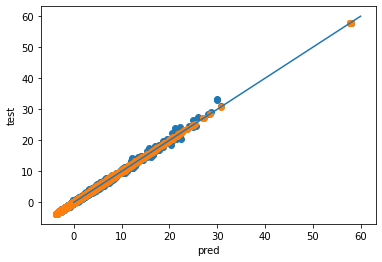

In [45]:
plt.scatter(model.predict(dtest) ,y_test)
plt.scatter(model.predict(dtrain) ,y_train)
plt.plot([0,60],[0,60])
plt.xlabel('pred')
plt.ylabel('test')
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

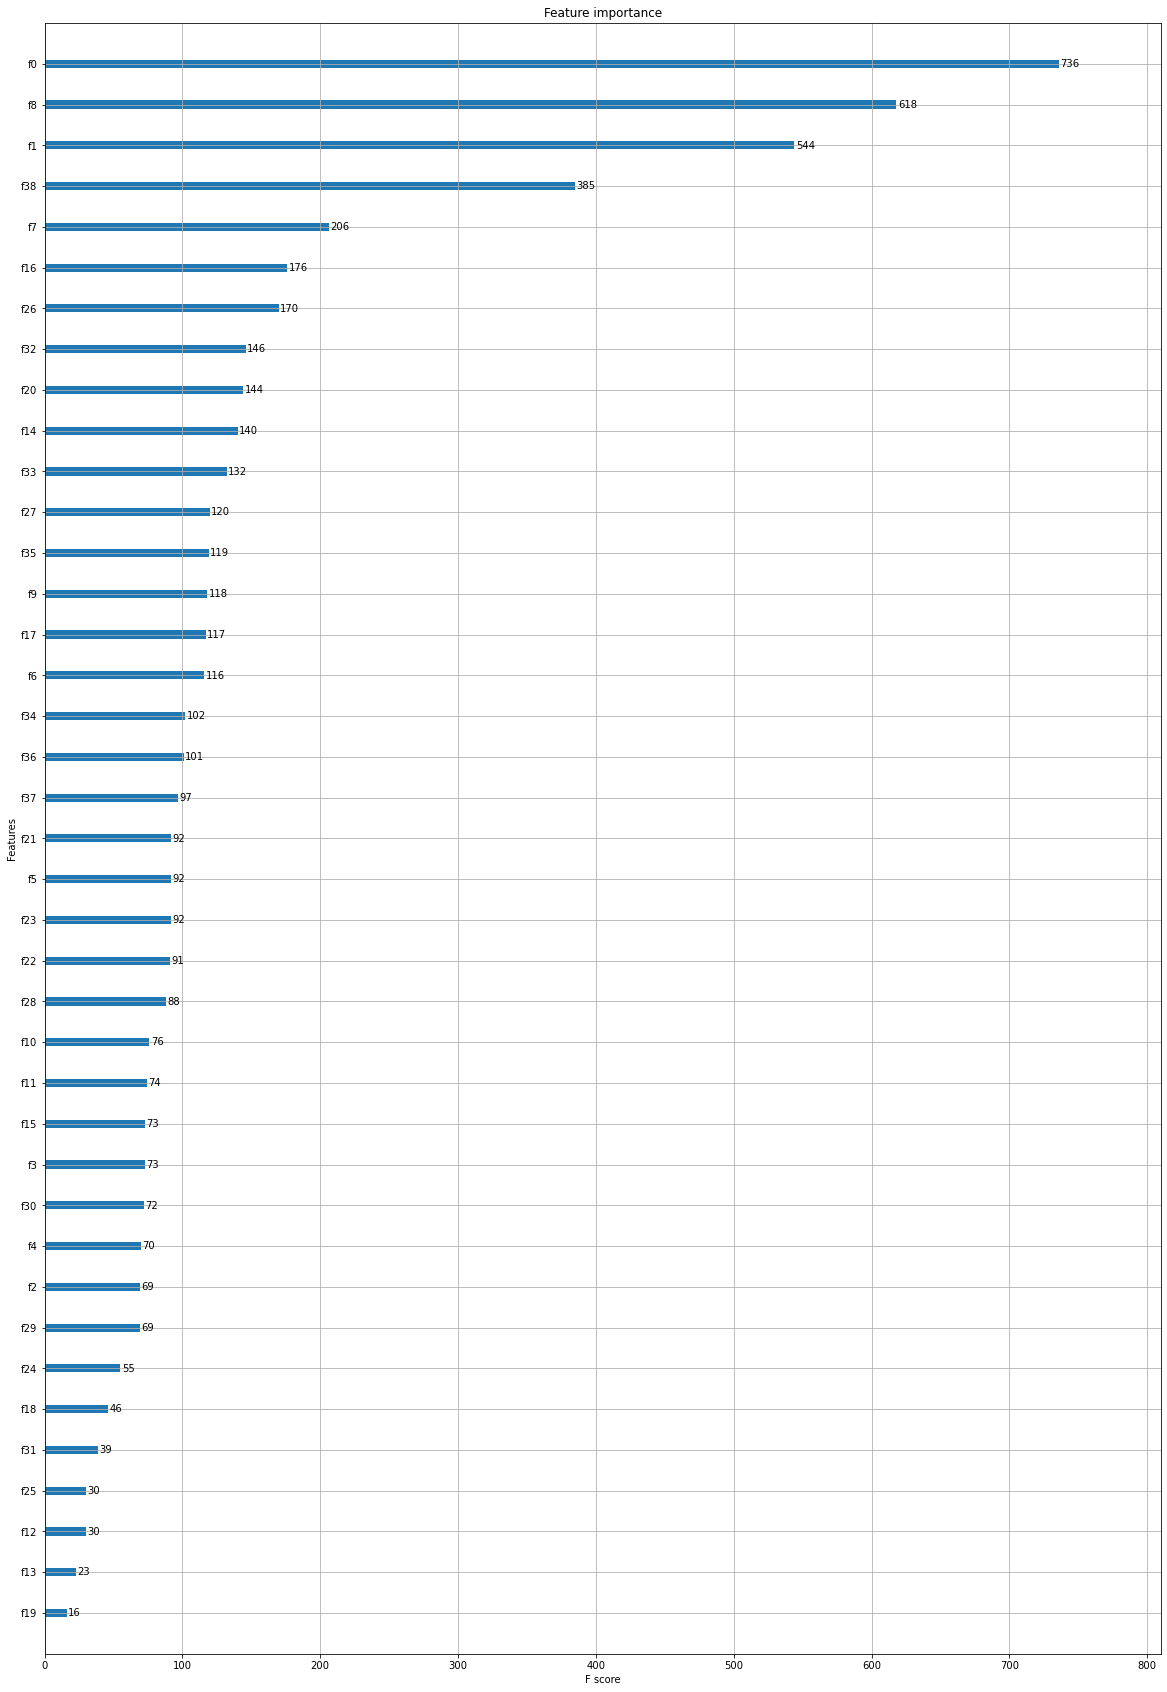

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,30)) 
xgb.plot_importance(model, ax=plt.gca())

In [24]:
model.save_model("model_Miryashkin_1.0.model")

# #loading xgboost model
# loaded_model = xgb.Booster()
# loaded_model.load_model("my_model_1.0.model")

# # And use it for predictions.
# ypred = loaded_model.predict(dtest)